In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!pip install efficientnet_pytorch


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.5 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=49da00e549e4e697a09089fb3f8f08aa1b2b3d89569f1791

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import pandas as pd
from PIL import Image
import os


In [ ]:
class RetinalDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx]['ID']
        img_path = os.path.join(self.root_dir, f"{img_id}.png")
        image = Image.open(img_path).convert('RGB')
        label = self.data.iloc[idx]['Disease_Risk']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((260, 260)),  # EfficientNet B2 input size is 260x260
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Standard normalization
])

# Load datasets
train_dataset = RetinalDataset(
    csv_file='/content/drive/MyDrive/eye_dataset/Training_Set/normalities_prob.csv',
    root_dir='/content/drive/MyDrive/eye_dataset/Training_Set/Training',
    transform=transform
)

val_dataset = RetinalDataset(
    csv_file='/content/drive/MyDrive/eye_dataset/Evaluation_Set/normalities_prob_val.csv',
    root_dir='/content/drive/MyDrive/eye_dataset/Evaluation_Set/Validation',
    transform=transform
)

test_dataset=RetinalDataset(
    csv_file='/content/drive/MyDrive/eye_dataset/Test_Set/normalities_prob.csv',
    root_dir='/content/drive/MyDrive/eye_dataset/Test_Set/Test',
    transform=transform

)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

In [ ]:
#Creating the subset from the val_loader

import torch
from torch.utils.data import DataLoader,Subset

indices= list(range(160));

val_subset_dataset= Subset(val_dataset,indices);

val_subset_loader=DataLoader(val_subset_dataset,batch_size=16,shuffle=False,num_workers=2)




In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))
print(len(val_subset_loader))

1920
640
640
10


In [ ]:
# Load EfficientNet B2
model = EfficientNet.from_pretrained('efficientnet-b2')

# Modify the final fully connected layer
model._fc = nn.Linear(model._fc.in_features, 1)


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth
100%|██████████| 35.1M/35.1M [00:00<00:00, 126MB/s]


Loaded pretrained weights for efficientnet-b2


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()  # because we have 1 output node
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
!pip install tqdm


In [ ]:
!pip install wandb

In [ ]:
import wandb

wandb.login()


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: jeevan-neupane002 (jeevan-neupane002-nepal-applied-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
print(len(train_dataset))
print(len(val_dataset))
print(len(val_subset_dataset))
print(len(test_dataset))

1920
640
160
640


In [ ]:
import torch
import wandb
from tqdm import tqdm

# Initialize wandb
wandb.init(project="Eye_Disease_Prediction_1")

# Training settings
num_epochs = 100
best_val_accuracy = 0.0

# Early Stopping settings
early_stopping_patience = 5    # Stop after 5 bad epochs
early_stopping_delta = 0.001   # Require at least this much improvement
early_stopping_counter = 0     # How many bad epochs so far

# Save dataset lengths
train_dataset_len = len(train_dataset)
val_dataset_len = len(val_dataset)

# Define the number of batches after which to trigger validation
validation_interval = 20  # Example: run validation every 20 batches


for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training", ncols=100)

    for batch_idx, (images, labels) in enumerate(train_loader_tqdm):
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        train_loss += loss.item() * batch_size

        preds = torch.sigmoid(outputs) > 0.5
        train_correct += (preds == labels.bool()).sum().item()
        train_total += batch_size

        # Log train batch loss
        wandb.log({
            'train_loss_batch': loss.item(),
            'train_accuracy_batch': train_correct / train_total  # Use accumulated batch accuracy
        }, step=batch_idx + 1)  # Use batch index for x-axis in the log

        # Update progress bar
        train_loader_tqdm.set_postfix(train_loss=loss.item())
        val_counter=0;

        # --- Perform validation after a fixed number of batches ---
        if (batch_idx + 1) % validation_interval == 0:
            # Validation loop
            model.eval()
            val_loss = 0.0
            val_correct = 0
            val_total = 0

            val_loader_tqdm = tqdm(val_subset_loader, desc=f"Validation after {batch_idx+1} batches", ncols=100)

            with torch.no_grad():
                for val_images, val_labels in val_loader_tqdm:
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device).unsqueeze(1)

                    val_outputs = model(val_images)

                    val_loss_batch = criterion(val_outputs, val_labels)
                    batch_size = val_images.size(0)
                    val_loss += val_loss_batch.item() * batch_size

                    val_preds = torch.sigmoid(val_outputs) > 0.5
                    val_correct += (val_preds == val_labels.bool()).sum().item()
                    val_total += batch_size

                    # Log val batch loss
                    val_counter+=1;
                    wandb.log({'val_subset_loss_batch': val_loss_batch.item()},step=val_counter);

                    # Update progress bar
                    val_loader_tqdm.set_postfix(val_loss=val_loss_batch.item())

            # Validation epoch metrics after the fixed number of batches
            val_loss /= val_dataset_len
            val_accuracy = val_correct / val_total

            # Log val epoch metrics
            wandb.log({
                'val_subset_loss_epoch': val_loss,
                'val_subset_accuracy_epoch': val_accuracy
            }, step=batch_idx + 1)

            # Print validation results after fixed batches
            print(f"Validation after {batch_idx+1}/{len(train_loader)} batches: "
                  f"Val Loss: {val_loss:.4f}  Val Acc: {val_accuracy:.4f}")

    # --- Perform validation after each epoch ---
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} Validation", ncols=100)

    with torch.no_grad():
        for val_images, val_labels in val_loader_tqdm:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).unsqueeze(1)

            val_outputs = model(val_images)

            val_loss_batch = criterion(val_outputs, val_labels)
            batch_size = val_images.size(0)
            val_loss += val_loss_batch.item() * batch_size

            val_preds = torch.sigmoid(val_outputs) > 0.5
            val_correct += (val_preds == val_labels.bool()).sum().item()
            val_total += batch_size

            # Log val batch loss
            wandb.log({'val_loss_batch': val_loss_batch.item()})

            # Update progress bar
            val_loader_tqdm.set_postfix(val_loss=val_loss_batch.item())

    # Validation epoch metrics after the entire epoch
    val_loss /= val_dataset_len
    val_accuracy = val_correct / val_total

    # Log val epoch metrics
    wandb.log({
        'val_loss_epoch': val_loss,
        'val_accuracy_epoch': val_accuracy
    }, step=epoch + 1)  # Use epoch number for x-axis in the log

    # Print validation results after the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss/train_dataset_len:.4f}  Train Acc: {train_correct/train_total:.4f} "
          f"Val Loss: {val_loss:.4f}  Val Acc: {val_accuracy:.4f}")

    # --- Best Model Saving and Early Stopping Check ---
    if val_accuracy > best_val_accuracy + early_stopping_delta:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), "/content/drive/MyDrive/retinal_classification_trained/best_model.pth")
        print(f"✅ Best model saved with Val Acc: {best_val_accuracy:.4f}")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        print(f"⚠️ No improvement in Val Acc for {early_stopping_counter} epoch(s).")

        if early_stopping_counter >= early_stopping_patience:
            print("⏹ Early stopping triggered! Training stopped.")
            break


Validation after 20 batches:  10%|█▉                 | 1/10 [00:12<01:53, 12.58s/it, val_loss=0.624]wandb: WARNING Tried to log to step 1 that is less than the current step 20. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 20. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.

Validation after 20 batches:  30%|█████▋             | 3/10 [00:20<00:41,  5.99s/it, val_loss=0.609]wandb: WARNING Tried to log to step 3 that is less than the current step 20. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 20. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-

Validation after 20/120 batches: Val Loss: 0.1460  Val Acc: 0.9250


Epoch 1/100 Training:  20%|████▍                 | 24/120 [02:05<06:38,  4.15s/it, train_loss=0.407]wandb: WARNING Tried to log to step 9 that is less than the current step 20. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 20. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Validation after 40 batches:  40%|███████▏          | 4/10 [00:08<00:10,  1.81s/it, val_loss=0.0827]wandb: WARNING Tried to log to step 1 that is less than the current step 40. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 40. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-

Validation after 40/120 batches: Val Loss: 0.0335  Val Acc: 0.9500


Epoch 1/100 Training:  36%|███████▉              | 43/120 [03:27<04:01,  3.14s/it, train_loss=0.333]wandb: WARNING Tried to log to step 5 that is less than the current step 40. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 40. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 40. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 40. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current 

Validation after 60/120 batches: Val Loss: 0.0368  Val Acc: 0.9313


Epoch 1/100 Training:  53%|███████████▋          | 64/120 [04:55<03:16,  3.51s/it, train_loss=0.223]wandb: WARNING Tried to log to step 9 that is less than the current step 60. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 60. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Validation after 80 batches:  40%|███████▌           | 4/10 [00:07<00:08,  1.50s/it, val_loss=0.261]wandb: WARNING Tried to log to step 1 that is less than the current step 80. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 80. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-

Validation after 80/120 batches: Val Loss: 0.0559  Val Acc: 0.9250


Epoch 1/100 Training:  68%|███████████████       | 82/120 [06:19<02:58,  4.71s/it, train_loss=0.433]wandb: WARNING Tried to log to step 5 that is less than the current step 80. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 80. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 80. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 80. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current 

Validation after 100/120 batches: Val Loss: 0.0525  Val Acc: 0.8750


Epoch 1/100 Training:  86%|██████████████████   | 103/120 [07:48<01:08,  4.06s/it, train_loss=0.389]wandb: WARNING Tried to log to step 7 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 100. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 1/100 Training: 100%|█████████████████████| 120/120 [09:0

Validation after 120/120 batches: Val Loss: 0.0231  Val Acc: 0.9688


Epoch 1/100 Validation:   0%|                                                | 0/40 [00:00<?, ?it/s]wandb: WARNING Tried to log to step 1 that is less than the current step 120. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 120. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 120. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 120. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the curr

Epoch [1/100] Train Loss: 0.3767  Train Acc: 0.8359 Val Loss: 0.3137  Val Acc: 0.8250
✅ Best model saved with Val Acc: 0.8250


Epoch 2/100 Training:   3%|▊                      | 4/120 [00:10<04:28,  2.32s/it, train_loss=0.378]wandb: WARNING Tried to log to step 1 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 2/100 Training:   8%|█▋                     | 9/120 [00:18

Validation after 20/120 batches: Val Loss: 0.0266  Val Acc: 0.9688


Epoch 2/100 Training:  22%|████▉                  | 26/120 [01:06<03:27,  2.21s/it, train_loss=0.23]wandb: WARNING Tried to log to step 9 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 21 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 22 that is less than the 

Validation after 40/120 batches: Val Loss: 0.0346  Val Acc: 0.9437


Epoch 2/100 Training:  39%|████████▌             | 47/120 [01:57<02:03,  1.69s/it, train_loss=0.246]wandb: WARNING Tried to log to step 9 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 41 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 42 that is less than the 

Validation after 60/120 batches: Val Loss: 0.0667  Val Acc: 0.8375


Epoch 2/100 Training:  54%|███████████▉          | 65/120 [02:49<02:34,  2.81s/it, train_loss=0.173]wandb: WARNING Tried to log to step 7 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 60 that is less than the cu

Validation after 80/120 batches: Val Loss: 0.0514  Val Acc: 0.8750


Epoch 2/100 Training:  72%|███████████████▊      | 86/120 [03:39<00:53,  1.56s/it, train_loss=0.205]wandb: WARNING Tried to log to step 7 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 80 that is less than the cu

Validation after 100/120 batches: Val Loss: 0.0288  Val Acc: 0.9375


Epoch 2/100 Training:  87%|██████████████████▏  | 104/120 [04:26<00:30,  1.92s/it, train_loss=0.299]wandb: WARNING Tried to log to step 5 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 120/120 batches: Val Loss: 0.0364  Val Acc: 0.9313


Epoch 2/100 Validation:  15%|███▍                   | 6/40 [00:08<00:36,  1.07s/it, val_loss=0.0307]wandb: WARNING Tried to log to step 9 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 120 that is less than the current step 160. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 2/100 Validation: 100%|███████████████████████| 40/40 [01:18<00:00,  1.96s/it, val_loss=0.443]


Epoch [2/100] Train Loss: 0.2742  Train Acc: 0.8807 Val Loss: 0.2552  Val Acc: 0.8828
✅ Best model saved with Val Acc: 0.8828


Epoch 3/100 Training:   5%|█▏                     | 6/120 [00:10<03:10,  1.67s/it, train_loss=0.326]wandb: WARNING Tried to log to step 1 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the curr

Validation after 20/120 batches: Val Loss: 0.0436  Val Acc: 0.9125


Epoch 3/100 Training:  19%|████▏                 | 23/120 [01:00<04:32,  2.80s/it, train_loss=0.177]wandb: WARNING Tried to log to step 3 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the curr

Validation after 40/120 batches: Val Loss: 0.0649  Val Acc: 0.8562


Epoch 3/100 Training:  38%|████████▍             | 46/120 [02:00<02:24,  1.95s/it, train_loss=0.113]wandb: WARNING Tried to log to step 7 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the cu

Validation after 60/120 batches: Val Loss: 0.0281  Val Acc: 0.9500


Epoch 3/100 Training:  53%|███████████▋          | 64/120 [02:47<01:53,  2.03s/it, train_loss=0.178]wandb: WARNING Tried to log to step 5 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 80/120 batches: Val Loss: 0.0279  Val Acc: 0.9437


Epoch 3/100 Training:  70%|████████████████       | 84/120 [03:37<01:08,  1.89s/it, train_loss=0.22]wandb: WARNING Tried to log to step 5 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 100/120 batches: Val Loss: 0.0368  Val Acc: 0.9500


Epoch 3/100 Training:  87%|█████████████████▎  | 104/120 [04:29<00:30,  1.93s/it, train_loss=0.0958]wandb: WARNING Tried to log to step 5 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 120/120 batches: Val Loss: 0.0422  Val Acc: 0.9125


Epoch 3/100 Validation:  18%|████▏                   | 7/40 [00:08<00:37,  1.14s/it, val_loss=0.129]wandb: WARNING Tried to log to step 9 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 120 that is less than the current step 200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 3/100 Validation: 100%|███████████████████████| 40/40 [01:17<00:00,  1.94s/it, val_loss=0.398]


Epoch [3/100] Train Loss: 0.2101  Train Acc: 0.9042 Val Loss: 0.2475  Val Acc: 0.8891
✅ Best model saved with Val Acc: 0.8891


Epoch 4/100 Training:   3%|▊                      | 4/120 [00:08<03:34,  1.85s/it, train_loss=0.235]wandb: WARNING Tried to log to step 1 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 4/100 Training:   8%|█▊                    | 10/120 [00:19

Validation after 20/120 batches: Val Loss: 0.0711  Val Acc: 0.8500


Epoch 4/100 Training:  20%|████▍                 | 24/120 [01:01<03:04,  1.92s/it, train_loss=0.229]wandb: WARNING Tried to log to step 3 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the curr

Validation after 40/120 batches: Val Loss: 0.0360  Val Acc: 0.9437


Epoch 4/100 Training:  40%|████████▊             | 48/120 [02:00<01:51,  1.55s/it, train_loss=0.213]wandb: WARNING Tried to log to step 9 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 41 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 42 that is less than the 

Validation after 60/120 batches: Val Loss: 0.0405  Val Acc: 0.9313


Epoch 4/100 Training:  55%|████████████          | 66/120 [02:46<01:26,  1.60s/it, train_loss=0.197]wandb: WARNING Tried to log to step 9 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 60 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 61 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 62 that is less than the 

Validation after 80/120 batches: Val Loss: 0.0517  Val Acc: 0.9062


Epoch 4/100 Training:  71%|██████████████▉      | 85/120 [03:40<01:09,  1.98s/it, train_loss=0.0688]wandb: WARNING Tried to log to step 5 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 100/120 batches: Val Loss: 0.0481  Val Acc: 0.9125


Epoch 4/100 Training:  88%|█████████████████▌  | 105/120 [04:29<00:27,  1.80s/it, train_loss=0.0393]wandb: WARNING Tried to log to step 5 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 120/120 batches: Val Loss: 0.0272  Val Acc: 0.9563


Epoch 4/100 Validation:  12%|██▋                  | 5/40 [00:08<01:02,  1.78s/it, val_loss=0.000849]wandb: WARNING Tried to log to step 9 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 120 that is less than the current step 240. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 4/100 Validation: 100%|███████████████████████| 40/40 [01:18<00:00,  1.96s/it, val_loss=0.545]


Epoch [4/100] Train Loss: 0.1691  Train Acc: 0.9318 Val Loss: 0.3644  Val Acc: 0.8875
⚠️ No improvement in Val Acc for 1 epoch(s).


Epoch 5/100 Training:   4%|▉                      | 5/120 [00:10<03:31,  1.84s/it, train_loss=0.232]wandb: WARNING Tried to log to step 1 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the curr

Validation after 20/120 batches: Val Loss: 0.0253  Val Acc: 0.9563


Epoch 5/100 Training:  18%|████▏                  | 22/120 [01:01<05:48,  3.55s/it, train_loss=0.19]wandb: WARNING Tried to log to step 3 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the curr

Validation after 40/120 batches: Val Loss: 0.1272  Val Acc: 0.8063


Epoch 5/100 Training:  38%|████████▍             | 46/120 [02:00<02:42,  2.19s/it, train_loss=0.175]wandb: WARNING Tried to log to step 7 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the cu

Validation after 60/120 batches: Val Loss: 0.0792  Val Acc: 0.8875


Epoch 5/100 Training:  55%|███████████▌         | 66/120 [02:50<01:30,  1.68s/it, train_loss=0.0427]wandb: WARNING Tried to log to step 7 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 60 that is less than the cu

Validation after 80/120 batches: Val Loss: 0.0473  Val Acc: 0.9062


Epoch 5/100 Training:  71%|██████████████▉      | 85/120 [03:40<01:11,  2.05s/it, train_loss=0.0765]wandb: WARNING Tried to log to step 5 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 100/120 batches: Val Loss: 0.0487  Val Acc: 0.9313


Epoch 5/100 Training:  87%|█████████████████▎  | 104/120 [04:30<00:32,  2.03s/it, train_loss=0.0473]wandb: WARNING Tried to log to step 5 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 120/120 batches: Val Loss: 0.0396  Val Acc: 0.9187


Epoch 5/100 Validation:  18%|████▏                   | 7/40 [00:09<00:40,  1.22s/it, val_loss=0.126]wandb: WARNING Tried to log to step 9 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 120 that is less than the current step 280. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 5/100 Validation: 100%|███████████████████████| 40/40 [01:17<00:00,  1.93s/it, val_loss=0.419]


Epoch [5/100] Train Loss: 0.1408  Train Acc: 0.9411 Val Loss: 0.2333  Val Acc: 0.8891
⚠️ No improvement in Val Acc for 2 epoch(s).


Epoch 6/100 Training:   4%|▉                      | 5/120 [00:10<03:42,  1.93s/it, train_loss=0.187]wandb: WARNING Tried to log to step 1 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the curr

Validation after 20/120 batches: Val Loss: 0.1105  Val Acc: 0.7312


Epoch 6/100 Training:  22%|████▊                 | 26/120 [01:01<02:45,  1.76s/it, train_loss=0.163]wandb: WARNING Tried to log to step 7 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the cu

Validation after 40/120 batches: Val Loss: 0.0741  Val Acc: 0.9062


Epoch 6/100 Training:  37%|████████              | 44/120 [01:49<02:37,  2.08s/it, train_loss=0.111]wandb: WARNING Tried to log to step 5 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 60/120 batches: Val Loss: 0.0673  Val Acc: 0.9125


Epoch 6/100 Training:  53%|███████████▋          | 64/120 [02:40<01:50,  1.97s/it, train_loss=0.131]wandb: WARNING Tried to log to step 5 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 80/120 batches: Val Loss: 0.0363  Val Acc: 0.9313


Epoch 6/100 Training:  69%|██████████████▌      | 83/120 [03:32<01:42,  2.78s/it, train_loss=0.0341]wandb: WARNING Tried to log to step 3 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the curr

Validation after 100/120 batches: Val Loss: 0.0611  Val Acc: 0.9125


Epoch 6/100 Training:  90%|██████████████████  | 108/120 [04:32<00:21,  1.82s/it, train_loss=0.0304]wandb: WARNING Tried to log to step 9 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 100 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 101 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 102 that is less than t

Validation after 120/120 batches: Val Loss: 0.0963  Val Acc: 0.8812


Epoch 6/100 Validation:   5%|█▏                      | 2/40 [00:02<00:37,  1.02it/s, val_loss=0.848]wandb: WARNING Tried to log to step 5 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 320. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Epoch [6/100] Train Loss: 0.1090  Train Acc: 0.9578 Val Loss: 0.4586  Val Acc: 0.8828
⚠️ No improvement in Val Acc for 3 epoch(s).


Epoch 7/100 Training:   2%|▍                      | 2/120 [00:03<03:07,  1.59s/it, train_loss=0.105]wandb: WARNING Tried to log to step 6 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 7/100 Training:   6%|█▎                    | 7/120 [00:14<03:28,  1.84s/it, train_loss=0.0913]wandb: WARNING Tried to log to step 3 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/defi

Validation after 20/120 batches: Val Loss: 0.0408  Val Acc: 0.9313


Epoch 7/100 Training:  22%|████▊                 | 26/120 [01:01<02:41,  1.72s/it, train_loss=0.188]wandb: WARNING Tried to log to step 7 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the cu

Validation after 40/120 batches: Val Loss: 0.0296  Val Acc: 0.9688


Epoch 7/100 Training:  37%|███████▋             | 44/120 [01:54<02:46,  2.19s/it, train_loss=0.0025]wandb: WARNING Tried to log to step 5 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 60/120 batches: Val Loss: 0.0627  Val Acc: 0.9125


Epoch 7/100 Training:  53%|███████████▏         | 64/120 [02:43<01:46,  1.90s/it, train_loss=0.0181]wandb: WARNING Tried to log to step 3 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the curr

Validation after 80/120 batches: Val Loss: 0.0796  Val Acc: 0.9250


Epoch 7/100 Training:  70%|██████████████      | 84/120 [03:34<01:13,  2.04s/it, train_loss=0.00933]wandb: WARNING Tried to log to step 3 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the curr

Validation after 100/120 batches: Val Loss: 0.0680  Val Acc: 0.8875


Epoch 7/100 Training:  84%|████████████████▊   | 101/120 [04:24<01:44,  5.51s/it, train_loss=0.0993]wandb: WARNING Tried to log to step 5 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 120/120 batches: Val Loss: 0.0865  Val Acc: 0.8875


Epoch 7/100 Validation:   8%|█▋                     | 3/40 [00:04<00:53,  1.43s/it, val_loss=0.0802]wandb: WARNING Tried to log to step 5 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 360. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Epoch [7/100] Train Loss: 0.0864  Train Acc: 0.9698 Val Loss: 0.3752  Val Acc: 0.8672
⚠️ No improvement in Val Acc for 4 epoch(s).


Epoch 8/100 Training:   2%|▎                     | 2/120 [00:06<05:00,  2.55s/it, train_loss=0.0864]wandb: WARNING Tried to log to step 7 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 1 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
Epoch 8/100 Training:   7%|█▌                     | 8/120 [00:15<02:57,  1.58s/it, train_loss=0.103]wandb: WARNING Tried to log to step 3 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/defi

Validation after 20/120 batches: Val Loss: 0.2058  Val Acc: 0.7937


Epoch 8/100 Training:  22%|████▎               | 26/120 [01:03<03:20,  2.14s/it, train_loss=0.00657]wandb: WARNING Tried to log to step 9 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 20 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 21 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 22 that is less than the 

Validation after 40/120 batches: Val Loss: 0.0876  Val Acc: 0.9125


Epoch 8/100 Training:  38%|███████▋            | 46/120 [01:55<02:02,  1.66s/it, train_loss=0.00354]wandb: WARNING Tried to log to step 7 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 40 that is less than the cu

Validation after 60/120 batches: Val Loss: 0.1201  Val Acc: 0.9187


Epoch 8/100 Training:  54%|██████████▎        | 65/120 [02:45<02:05,  2.28s/it, train_loss=0.000469]wandb: WARNING Tried to log to step 7 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 10 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 60 that is less than the cu

Validation after 80/120 batches: Val Loss: 0.0950  Val Acc: 0.9062


Epoch 8/100 Training:  70%|███████████████▍      | 84/120 [03:35<01:14,  2.07s/it, train_loss=0.016]wandb: WARNING Tried to log to step 5 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Validation after 100/120 batches: Val Loss: 0.0648  Val Acc: 0.9437


Epoch 8/100 Training:  87%|████████████████▍  | 104/120 [04:27<00:30,  1.92s/it, train_loss=0.00137]wandb: WARNING Tried to log to step 3 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the curr

Validation after 120/120 batches: Val Loss: 0.0503  Val Acc: 0.9375


Epoch 8/100 Validation:   5%|█▏                      | 2/40 [00:03<01:00,  1.60s/it, val_loss=0.306]wandb: WARNING Tried to log to step 5 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 6 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 7 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 8 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 9 that is less than the curr

Epoch [8/100] Train Loss: 0.0526  Train Acc: 0.9797 Val Loss: 0.4044  Val Acc: 0.8750
⚠️ No improvement in Val Acc for 5 epoch(s).
⏹ Early stopping triggered! Training stopped.


In [ ]:
import torch
import wandb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Initialize wandb for logging
wandb.init(project="Retinal_Diseases")

# Set model to evaluation mode
model.eval()

# Initialize variables for calculating the loss and accuracy
test_loss = 0.0
correct = 0
total = 0
all_preds = []
all_labels = []

# Use tqdm for the test loop
test_loader_tqdm = tqdm(test_loader, desc="Testing", ncols=100)

with torch.no_grad():
    for images, labels in test_loader_tqdm:
        images = images.to(device)
        labels = labels.to(device).unsqueeze(1)  # Ensure labels are the correct shape

        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

        preds = torch.sigmoid(outputs) > 0.5  # threshold 0.5 for binary classification
        correct += (preds == labels.bool()).sum().item()
        total += labels.size(0)

        # Store predictions and labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update the tqdm progress bar with the current loss
        test_loader_tqdm.set_postfix(test_loss=loss.item())

# Calculate average test loss and accuracy
test_loss /= len(test_loader.dataset)
test_acc = correct / total

# Log the test loss and accuracy to WandB
wandb.log({'test_loss': test_loss, 'test_accuracy': test_acc})

# Print out test results
print(f"Test Loss: {test_loss:.4f}  Test Accuracy: {test_acc:.4f}")




train_accuracy_epoch,▁▃▅▆▇██
train_loss_batch,█▃█▆▆▄▄▄▆▂▃▃▆▃▂▄▂▄▂▂▂▅▃▁▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▁
train_loss_epoch,█▆▄▃▂▁▁
val_accuracy_epoch,▁█▄▁█▇▇
val_loss_batch,▂▂▂▂▂▃▂▁▁▁▂▂▁▁▂▁▁▁▃▃▂▂▂▂▁▂▂▁▇▂▂▂▂▅▂█▁▁▃▂
val_loss_epoch,▂▁▄█▃▆▆
train_accuracy_epoch,0.9875
train_loss_batch,0.0618
train_loss_epoch,0.03707
val_accuracy_epoch,0.88438
val_loss_batch,0.78891


Testing: 100%|█████████████████████████████████████| 40/40 [06:29<00:00,  9.75s/it, test_loss=0.672]

Test Loss: 0.2640  Test Accuracy: 0.9203


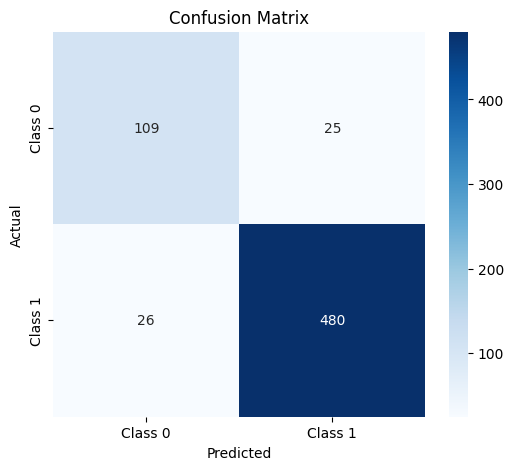

In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

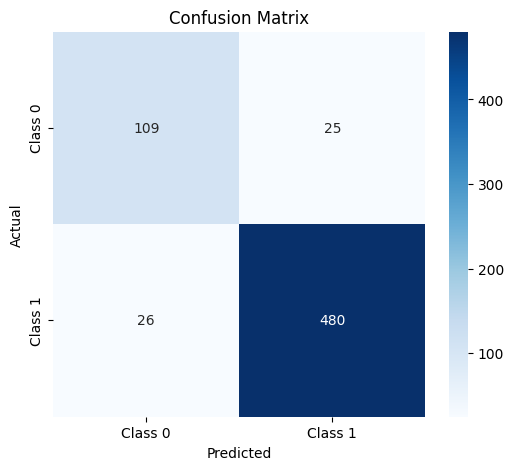

Accuracy: 0.9203
Precision: 0.9505
Recall: 0.9486
F1-Score: 0.9496


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Assuming `all_labels` and `all_preds` are your true labels and predicted labels respectively

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Now, calculate the performance metrics
TP = cm[1, 1]  # True Positives
TN = cm[0, 0]  # True Negatives
FP = cm[0, 1]  # False Positives
FN = cm[1, 0]  # False Negatives

# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP)

# Recall
recall = TP / (TP + FN)

# F1-Score
f1 = 2 * (precision * recall) / (precision + recall)

# Log the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
